In [2]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

## Carregamento dos dados

In [3]:
dct = {}
dct['codigo'] = 'boi-gordo'

In [4]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

---

## Análise Exploratória dos dados

In [5]:
df['cotacao_dolar'] = df.preco_real / df.preco_dolar
df['preco_diff1'] = df.preco_dolar.diff()
df # O missing value gerado será automaticamente eliminado no slice abaixo

,preco_real,preco_dolar,cotacao_dolar,preco_diff1
data,,,,
23/07/1997,26.67,24.65,1.081947,NaN
24/07/1997,26.67,24.65,1.081947,0.00
25/07/1997,26.71,24.68,1.082253,0.03
28/07/1997,26.74,24.70,1.082591,0.02
29/07/1997,26.77,24.72,1.082929,0.02
...,...,...,...,...
22/12/2020,262.80,50.88,5.165094,-0.09
23/12/2020,266.30,51.22,5.199141,0.34
28/12/2020,270.30,51.59,5.239387,0.37


In [6]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

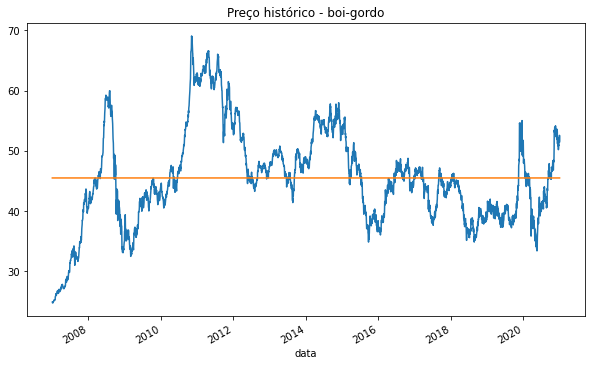

In [7]:
# Gráfico de preços em dólar
copy = df.copy()
copy['media'] = df.preco_dolar.mean()
copy.preco_dolar.plot(figsize=(10,6))
copy.media.plot()
plt.title(f'Preço histórico - {dct["codigo"]}')
plt.show()

<AxesSubplot:title={'center':'Histograma - boi-gordo'}>

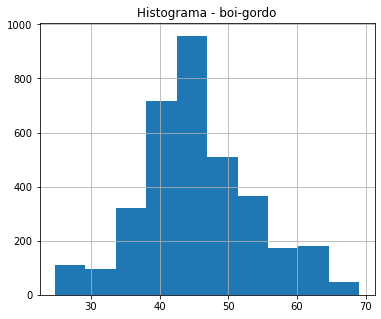

In [8]:
plt.title(f'Histograma - {dct["codigo"]}')
df.preco_dolar.hist(figsize=(6,5))

In [9]:
df.preco_dolar.describe()

count    3481.000000
mean       45.498558
std         8.169509
min        24.740000
25%        40.090000
50%        44.970000
75%        49.740000
max        69.060000
Name: preco_dolar, dtype: float64

#### Tomando a 1ª Diferença

<AxesSubplot:title={'center':'Histograma - boi-gordo - 1ª Diferença'}>

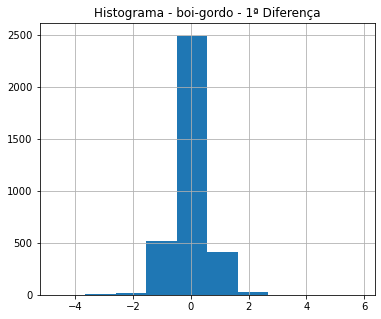

In [10]:
plt.title(f'Histograma - {dct["codigo"]} - 1ª Diferença')
df.preco_diff1.hist(figsize=(6,5))

<AxesSubplot:title={'center':'Preço histórico - boi-gordo - 1ª Diferença'}, xlabel='data'>

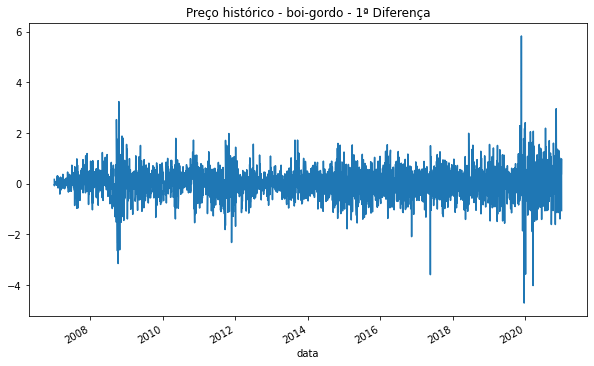

In [11]:
plt.title(f'Preço histórico - {dct["codigo"]} - 1ª Diferença')
df.preco_diff1.plot(figsize=(10,6))

In [12]:
def adf_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
# ADF TEST - Série de Preço dolarizado
adf_test(df.preco_dolar)

ADF Statistic: -3.291882
p-value: 0.015245
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [39]:
# ADF TEST - Série de Preço dolarizado
adf_test(np.log(df.preco_dolar))

ADF Statistic: -3.559421
p-value: 0.006586
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [15]:
# ADF TEST - Primeira Diferença
adf_test(df.preco_diff1)

ADF Statistic: -13.541162
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [16]:
def acf_pacf(series):
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series,lags=10, ax=ax1)
    fig.tight_layout()

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series,lags=10, ax=ax2)
    fig.tight_layout()
    plt.show()
    
    # Scatter plot entre (t) e (t-1)
    plt.figure(figsize=(6,6))
    pd.plotting.lag_plot(series, lag=1)

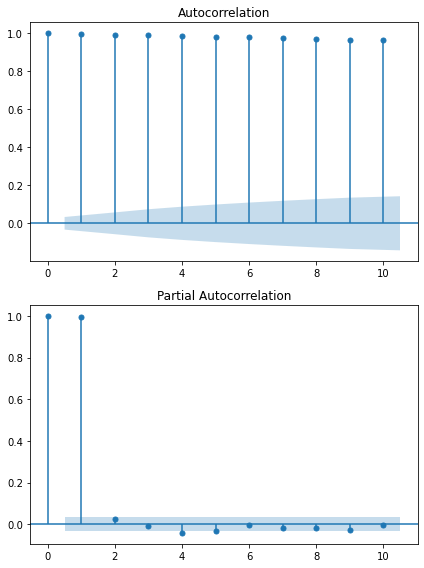

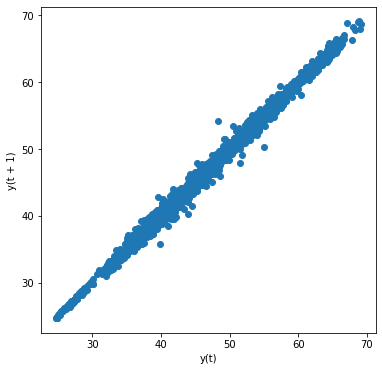

In [17]:
# ACF e PACF - preço dolarizado
acf_pacf(df.preco_dolar)

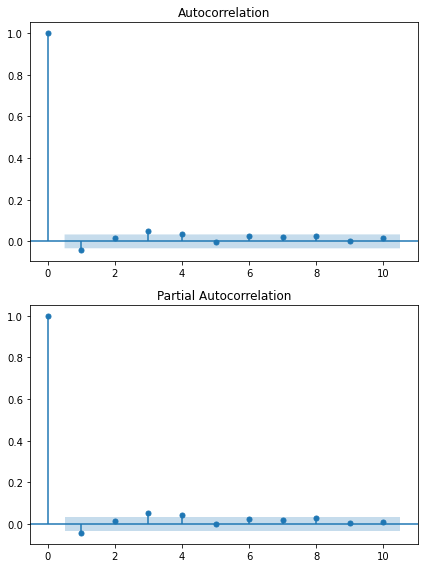

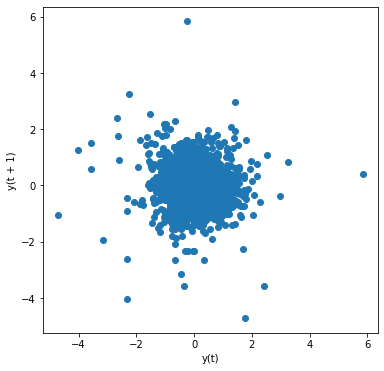

In [18]:
# ACF e PACF - preço dolarizado
acf_pacf(df.preco_diff1)

---

#### Decomposição da série

In [19]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_real       False
preco_dolar      False
cotacao_dolar    False
preco_diff1      False
dtype: bool

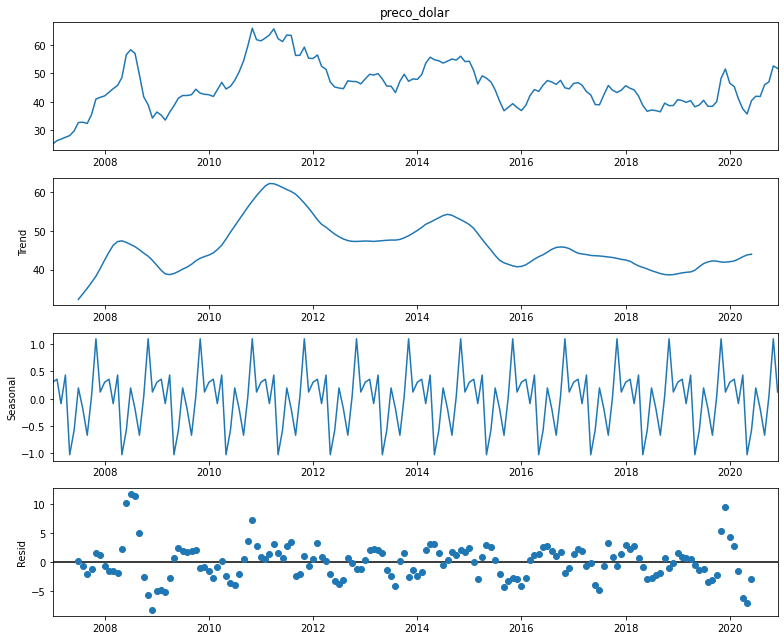

In [20]:
# Decomposição da série mensal em tendência, sazonalidade e resíduos
series = df_mes.preco_dolar

rcParams['figure.figsize'] = 11, 9
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

---

# <center>Desenvolvimento de Modelos Preditivos</center>

## MODELOS ARIMA

**Serão gerados 3 modelos:**

**1)** Com um *resample* dos dados para periodicidade mensal, faremos uma projeção pontual, ao fim do dataset de treino, para todo o dataframe de teste. Criaremos:  
    ... **1.1)** Um modelo com a ordem pdq do ARIMA definido via força bruta pelo melhor AIC (Critério de Informação de Akaike) e;   
    ... **1.2)** Outro, com a melhor ordem do Arima estimada pelo Auto-ARIMA.  
    
(Ambos serão confrontados via estatística de erro absoluto médio MAE.)  
  
**2)** Com os dados originais, periodicidade diária, faremos a projeção "dia a dia" do dataframe de test (janela móvel), com o Auto ARIMA (ordem automática)

In [21]:
# !pip install pmdarima --user

In [22]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from math import sqrt
import pprint

In [23]:
# Gera train e test sets

# Primeiro, faremos os modelos na periodicidade mensal (para a projeção pontual ao final do período de treino)
sep = df_mes.index.year >= 2019
train = df_mes.preco_dolar[~sep]
test = df_mes.preco_dolar[sep]

# Depois, o modelo diário
sep_oa = df.index.year >= 2020
sep_om = df.index.month > 6
train_o = df.preco_dolar[~(sep_oa & sep_om)]
test_o = df.preco_dolar[sep_oa & sep_om]

mae = {}

#### Brute Force AIC

In [24]:
# Busca pela melhor ordem do modelo ARIMA conforme Critério de Informação de Akaike
# Quanto menor a perda de informação, teoricamente, melhor

pdq = []
akaike = []

# Aplica o modelo ARIMA para todas as combinações de pdq que recebe
def objfunc(order, exog):
    fit = ARIMA(exog, order=order).fit()
    return fit.aic    

# Gera todas as "combinações" de pdq de 000 a 222 e roda o modelo para todas
for order in product(range(3), repeat=3):
    akaike.append(objfunc(order, train))
    pdq.append(order)

C:\Users\conta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\conta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


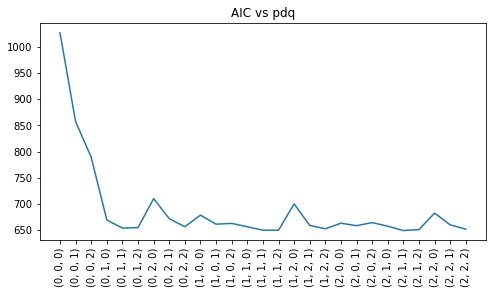

In [25]:
# Plota AIC conforme as ordens do modelo ARIMA
plt.figure(figsize=(8,4))
plt.title('AIC vs pdq')
plt.plot(akaike)
plt.xticks(np.arange(len(akaike)), pdq)
plt.xticks(rotation=90)
plt.show()

In [26]:
# AIC para cada order de ARIMA
# dict(zip(pdq,akaike))

In [27]:
# MELHOR MODELO SEGUNDO CRITÉRIO DE INFORMAÇÃO DE AKAIKE
# Priorizando a primeira ocorrência - menor ordem - em caso de pequena vantagem de ordens maiores
func = np.vectorize(lambda x: 0 if (abs(x) < 10) else x)
trans_akaike = func(np.diff(akaike).astype(int))
best_aic = pdq[(np.argmax(trans_akaike == 0))]
best_aic # Se uma ordem superior tiver apenas pouca vantagem, será ignorada

(0, 1, 1)

In [28]:
# Funções geradoras de gráficos

# Plot Previsto vs. real
def prev_real(ref, tr, tt, forecast):
    x = ref.index
    plt.title('Previsões (verde) vs. Valores reais (vermelho)')
    plt.plot(x[:tr.size], tr, c='blue')
    plt.plot(x[tr.size:], tt, c='red')
    plt.plot(x[tr.size:], forecast, c='green')
    plt.show()
    
# Plot de resíduos
def show_resid(m):
    # Análise dos resíduos
    residuals = pd.DataFrame(m)
    rcParams['figure.figsize'] = 8, 4
    residuals.plot()
    plt.title('Gráfico de linha dos resíduos')
    plt.show()
    # kde dos resíduos
    residuals.plot(kind='kde')
    plt.title('Distribuição dos resíduos')
    plt.show()
    # resumo dos resíduos
    print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:            preco_dolar   No. Observations:                  144
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -324.943
Date:                Wed, 13 Jan 2021   AIC                            653.886
Time:                        14:53:03   BIC                            659.812
Sample:                    01-01-2007   HQIC                           656.294
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3885      0.076      5.145      0.000       0.241       0.537
sigma2         5.5049      0.574      9.585      0.000       4.379       6.631
Ljung-Box (L1) (Q):                   0.11   Jarque-

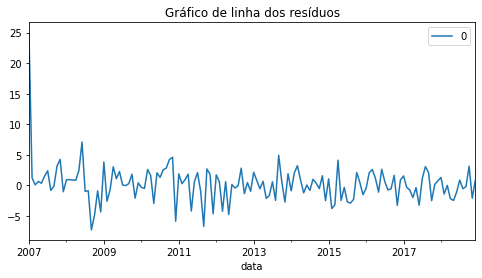

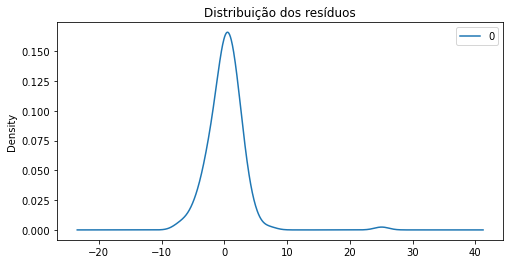

                0
count  144.000000
mean     0.244150
std      3.136060
min     -7.286034
25%     -1.056888
50%      0.359831
75%      1.664567
max     25.051364


In [29]:
# Treina o modelo com a melhor ordem do ARIMA, segundo critério AIC, escolhido via "força bruta"
model = ARIMA(train, order=best_aic)
model_fit = model.fit()

# Gera forecasts - para períodos out-of-sample (não treinados)
# Se fosse no período treinado, usaríamos predict
aic_forecasts = model_fit.forecast(test.size)

# Sumário do modelo
print(model_fit.summary())

# Mostra gráficos
show_resid(model_fit.resid)

# Salva estatística de erro
mae['aic_brute'] = {}
mae['aic_brute']['order'] = best_aic
mae['aic_brute']['mae'] = mean_absolute_error(test, aic_forecasts)

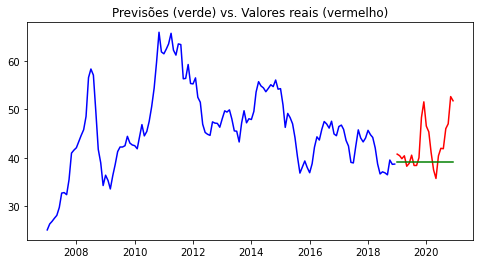

In [30]:
prev_real(df_mes, train, test, aic_forecasts)

#### Auto ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -322.307
Date:                Wed, 13 Jan 2021   AIC                            656.614
Time:                        14:53:10   BIC                            674.433
Sample:                             0   HQIC                           663.855
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6808      1.444      2.549      0.011       0.851       6.511
ar.L1          0.4681      0.096      4.892      0.000       0.281       0.656
ar.L2          0.6261      0.130      4.824      0.0

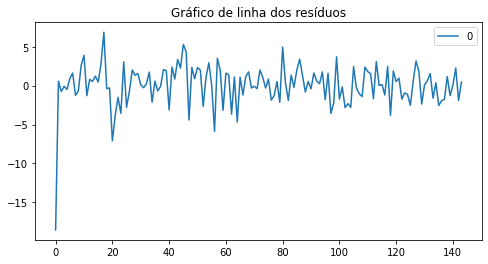

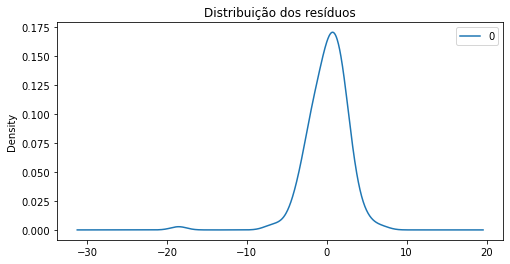

                0
count  144.000000
mean     0.043698
std      2.707821
min    -18.541176
25%     -1.287056
50%      0.355808
75%      1.659165
max      6.862489


In [31]:
# Gera Auto ARIMA
# Por padrão da biblioteca, o critério de informação é o AIC (também) e o teste de estacionariedade é o KPSS
model = pm.auto_arima(train, seasonal=True, m=12) # Adicionamos a opção de sazonalidade
print(model.summary())

# Gera Previsões
auto_forecasts = model.predict(test.shape[0])

show_resid(model.resid())

# Salva estatística de erro
mae['auto_arima'] = {}
mae['auto_arima']['order'] = model.order
mae['auto_arima']['mae'] = mean_absolute_error(test, auto_forecasts)

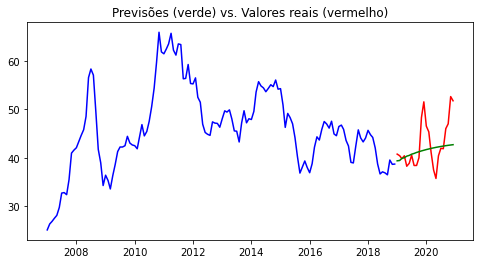

In [32]:
# Mostra previsões (azul=train, vermelho=test, verde=forecasts)
prev_real(df_mes, train, test, auto_forecasts)

In [33]:
# Estatísticas de erro

menor_mae = np.inf

for k, c in mae.items():
    if c['mae'] < menor_mae:
        menor_mae = c['mae']
        melhor_order = c['order']
        melhor_metodo = k

print('Lista de erros:')
pprint.pprint(mae)
print('\n')
print("=" * 50)
print('\n')
[]

print(f'*{melhor_metodo.upper()}* ==> obteve o melhor resultado')
print(f'{melhor_order} ==> foi a ordem pdq')
print(f'{menor_mae} ==> é o erro absoluto médio')
print('\n')
print("=" * 50)

Lista de erros:
{'aic_brute': {'mae': 4.2109382858691795, 'order': (0, 1, 1)},
 'auto_arima': {'mae': 3.3419954312199516, 'order': (3, 0, 1)}}




*AUTO_ARIMA* ==> obteve o melhor resultado
(3, 0, 1) ==> foi a ordem pdq
3.3419954312199516 ==> é o erro absoluto médio




### PREVISÃO MÓVEL

Com a série na periodicidade original (diária), faremos uma previsão móvel, em que, a cada passo, é previsto apenas o próximo valor da variável *target*, incluindo o seu valor real e reexecutando os passos, até chegar ao final.

In [34]:
history = [x for x in train_o]
predictions = list()

# Seleciona a melhor ordem do ARIMA, automaticamente
model = pm.auto_arima(history)
order_selected = model.order

# Loop que caminha ponto a ponto
for t in range(len(test_o)):
    model = ARIMA(history, order=order_selected).fit()
    if t == 0: print(model.summary())
    yhat = model.forecast()[0]
    
    # Gera Previsões
    predictions.append(yhat)
    obs = test_o[t]
    history.append(obs)
    # print('predito=%f, real=%f' % (yhat, obs))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3355
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2877.322
Date:                Wed, 13 Jan 2021   AIC                           5762.644
Time:                        14:53:33   BIC                           5787.116
Sample:                             0   HQIC                          5771.397
                               - 3355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9149      0.031     29.812      0.000       0.855       0.975
ma.L1         -0.9524      0.034    -27.999      0.000      -1.019      -0.886
ma.L2          0.0644      0.011      5.687      0.0

In [35]:
# Avalia previsões
mae_movel = mean_absolute_error(test_o, predictions)
print('MAE: %.3f' % mae_movel)

MAE: 0.599


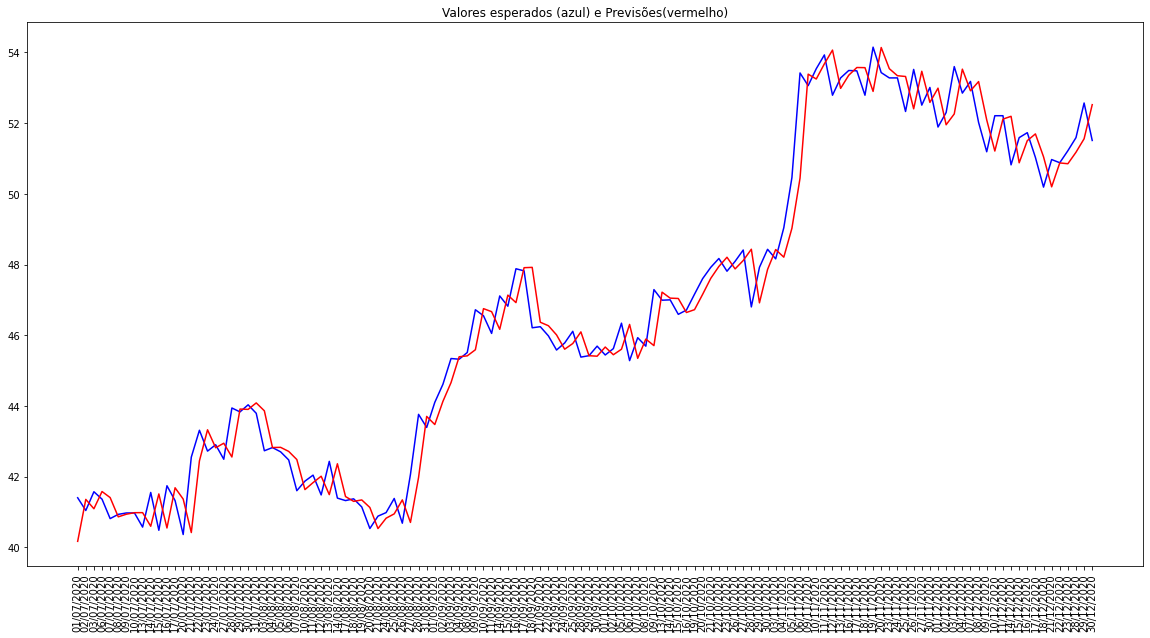

In [36]:
# plot previsões contra valores esperados
rcParams['figure.figsize'] = 20, 10

plt.plot(test_o.values, color='blue')
plt.plot(predictions, color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho)')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.show()

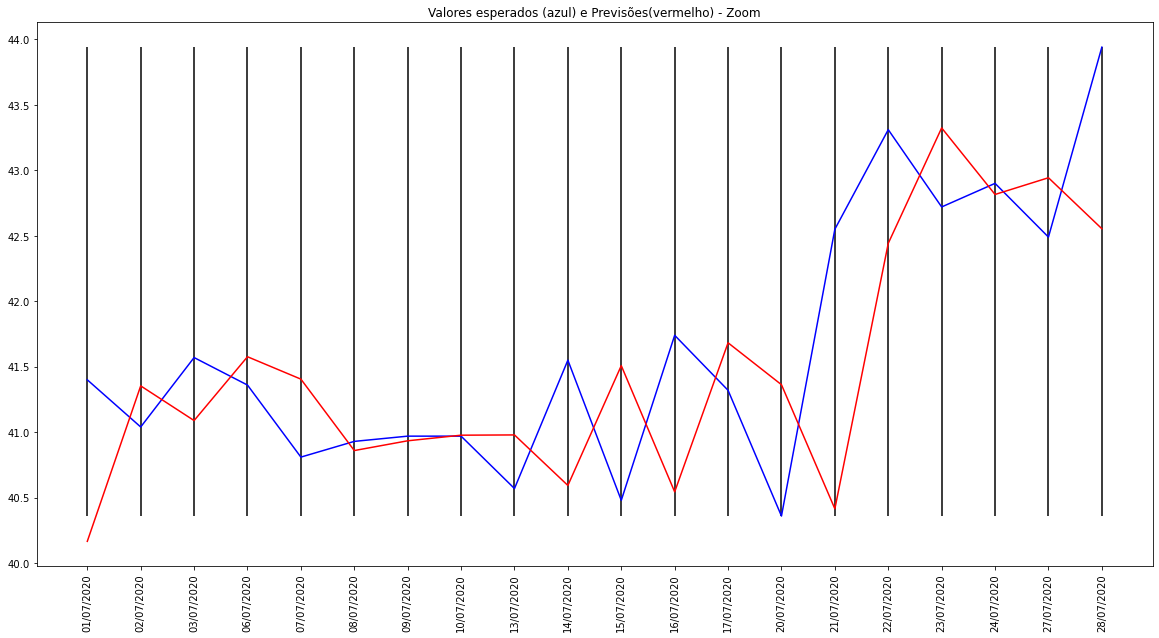

In [37]:
# plot previsões contra valores esperados, com zoom e linhas verticais
limite = slice(20)

plt.plot(test_o.values[limite], color='blue')
plt.plot(predictions[limite], color='red' )
plt.title('Valores esperados (azul) e Previsões(vermelho) - Zoom')
plt.xticks(np.arange(test_o.size),test_o.index.strftime("%d/%m/%Y"))
plt.xticks(rotation=90)
plt.vlines(np.arange(test_o.size)[limite], ymin=min(test_o[limite]), ymax=max(test_o[limite]), colors='k', linestyles='solid')
plt.show()

In [38]:
a_r = result.resid.max()-result.resid.min()
a_s = result.seasonal.max()-result.seasonal.min()
print(f'Amplitude residual de {dct["codigo"]}: {"{:.2f}".format(a_r)}')
print(f'Amplitude sazonal de {dct["codigo"]}: {"{:.2f}".format(a_s)}')
print(f'Relação amplitude residual / sazonal:  {"{:.2f}".format(a_r/a_s)}')

Amplitude residual de boi-gordo: 19.95
Amplitude sazonal de boi-gordo: 2.12
Relação amplitude residual / sazonal:  9.40
